# <p style="text-align: center;">Do you need more signs?</p>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from PIL import Image # Install Pillow -> conda install anaconda::pillow or pip install pillow
import os
from skimage.io import  imread, imshow # Install scikit-image -> conda install scikit-image or pip install scikit-image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import re
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split

device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():    
    device = torch.device("cuda")

print("DEVICE: ", device)

train_dataset_path = 'data/TRAIN'
test_dataset_path = 'data/TEST'
predictions_path= 'predictions/'
results_path = 'results/'

IMG_WIDTH = 75
IMG_HEIGHT = 75
BATCH_SIZE = 32

DEVICE:  mps


## Data Import

In [30]:
class TestDataset(Dataset):
    def get_int(self, text):
        return [int(c) if c.isdigit() else c for c in re.split('(\d+)', text)]
    
    def __init__(self, images_folder, transform=None):
        self.images_folder = images_folder
        self.image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]
        self.image_files.sort(key=self.get_int)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),transforms.ToTensor()])
train_original_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)

inference_dataset = TestDataset(images_folder=test_dataset_path, transform=transform)
test_loader = DataLoader(inference_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
train_size = len(train_original_dataset)
test_size = len(inference_dataset)

print("Train size: ", train_size)
print("Test size: ", test_size)

Train size:  277
Test size:  340


**Get the Label Mappings**

In [5]:
### subset version
#the_labels = {value for _, value in train_datagen.class_to_idx.items()}
labels = {value: key for key, value in train_original_dataset.class_to_idx.items()}
print(labels)
the_real_labels = {}
with open("data/labels.csv","r") as label_f:
    for line in label_f.readlines()[1:]:
        label_value, label_description = line.strip().split(";")
        the_real_labels[int(label_value)] = label_description 

print(the_real_labels)

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value} - {the_real_labels[int(value)]}")
the_labels_map = {key: value for key, value in train_original_dataset.class_to_idx.items()}
print(len(labels))

{0: '12', 1: '13', 2: '24', 3: '38', 4: '39', 5: '44', 6: '46', 7: '49', 8: '50', 9: '6'}
{6: 'Speed limit (70km/h)', 12: 'Dont Go Left or Right', 13: 'Dont Go Right', 24: 'Go Right', 37: 'Children crossing', 38: 'Dangerous right curve', 39: 'Dangerous left curve', 44: 'Go left or straight', 46: 'Zig-zag Curve', 49: 'Unknown 5', 50: 'Fences'}
Label Mappings for classes present in the training and validation datasets

0 : 12 - Dont Go Left or Right
1 : 13 - Dont Go Right
2 : 24 - Go Right
3 : 38 - Dangerous right curve
4 : 39 - Dangerous left curve
5 : 44 - Go left or straight
6 : 46 - Zig-zag Curve
7 : 49 - Unknown 5
8 : 50 - Fences
9 : 6 - Speed limit (70km/h)
10


## Initial Data Analysis

**Plotting of each available sign**

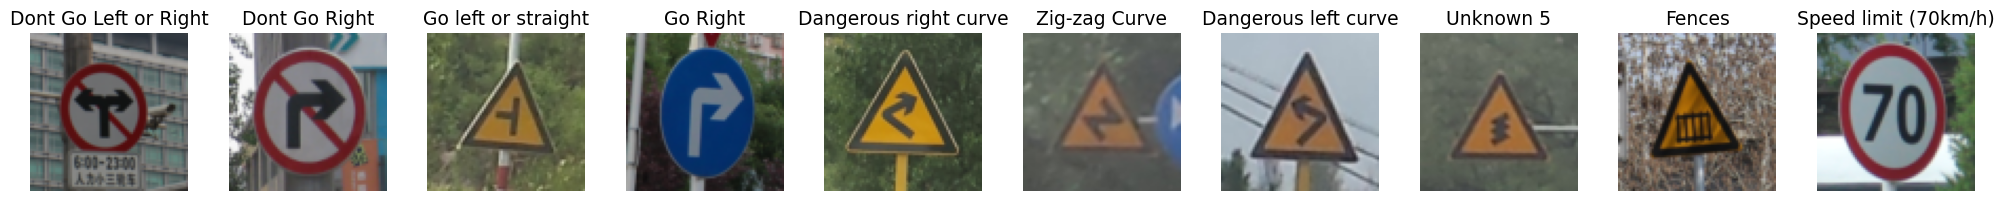

In [6]:

class_names = train_original_dataset.classes
num_classes = len(class_names)
fig, axs = plt.subplots(1, num_classes, figsize=(2*num_classes, 2))

# Specify the new order you want
new_order = [0, 1, 5, 2, 3, 6,4, 7, 8,9]  # Adjust this list based on the actual positions you want to switch

for i, new_idx in enumerate(new_order):
    class_name = class_names[new_idx]
    # Find the first image of this class
    for img, label in train_original_dataset:
        if label == new_idx:
            axs[i].imshow(img.permute(1, 2, 0))
            axs[i].set_title(the_real_labels[int(class_name)], fontsize=13.5)
            axs[i].axis('off')
            break

plt.tight_layout()
plt.savefig(results_path + 'classes.png')
plt.show()


Corrected label from Unknown to Zig-zag Curve and Unk1 to Unkown 5 accoring to the problem statement

**Imbalance**

In [7]:
training_targets = train_original_dataset.targets
t_targets = {k:0 for k in training_targets}
for t in training_targets:
    t_targets[t] += 1
print('Training class distribution:', t_targets)

Training class distribution: {0: 12, 1: 10, 2: 8, 3: 30, 4: 34, 5: 30, 6: 9, 7: 10, 8: 56, 9: 78}


{'Speed limit (70km/h)': 78, 'Fences': 56, 'Dangerous left curve': 34, 'Dangerous right curve': 30, 'Go left or straight': 30, 'Dont Go Left or Right': 12, 'Dont Go Right': 10, 'Unknown 5': 10, 'Zig-zag Curve': 9, 'Go Right': 8}


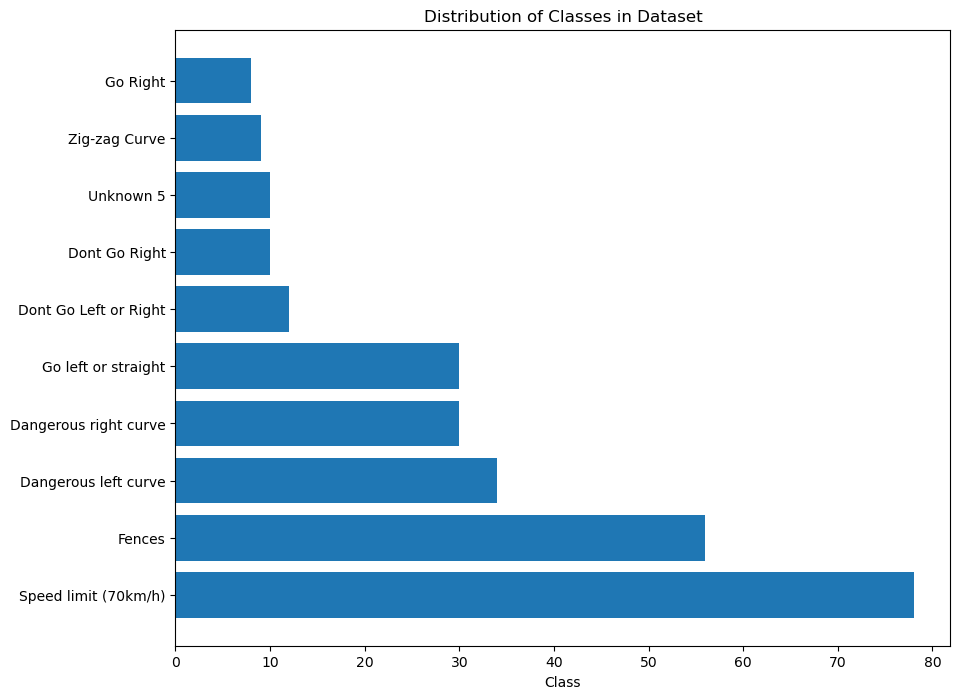

In [8]:
# Assuming train_datagen is your ImageFolder dataset
class_counts = {}
for _, label in train_original_dataset:
    class_name = train_original_dataset.classes[label]
    real_label = the_real_labels[int(class_name)]
    if real_label in class_counts:
        class_counts[real_label] += 1
    else:
        class_counts[real_label] = 1

# Sorting classes alphabetically or by count, based on your preference
class_counts = {k: v for k, v in sorted(class_counts.items(), key=lambda item: item[1], reverse=True)}

print(class_counts)

# Plotting
plt.figure(figsize=(10, 8))

plt.barh(list(class_counts.keys()), list(class_counts.values()))
plt.xlabel('Class')
plt.title('Distribution of Classes in Dataset')
plt.savefig(results_path + 'class_distribution.png')
plt.show()

## Data generations
Category models should be only concern unsupervised learning due to lack of data and the need for generation

In [ ]:
train_idx, valid_idx = train_test_split(
    range(len(train_original_dataset)),
    test_size=0.1,
    shuffle=True,
    stratify=train_original_dataset.targets
)

train_subset = Subset(train_original_dataset, train_idx)
valid_subset = Subset(train_original_dataset, valid_idx)

train_dataset_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
validation_dataset_loader = DataLoader(valid_subset, batch_size=64, shuffle=False)

### Auto-encoders

In [36]:
class Autoencoder(nn.Module):
    def __init__(self, color_channels=3, width=75, height=75):
        super().__init__()
        self.encoder=nn.Sequential(
            nn.Conv2d(color_channels, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True)
            )
        
        self.decoder=nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, color_channels, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.Tanh()
            )
        
    def forward(self,x):
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)
        return decoded

def train_autoencoder(model, data_loader, num_epochs=50, device='cpu'):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=1e-3, 
                                weight_decay=1e-5)

    outputs=[]
    model = model.to(device)
    for epoch in range(num_epochs):
        
        for(img, _) in data_loader:
            img=img.to(device)
            recon=model(img)
            loss=criterion(recon, img)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        
        print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
        outputs.append((epoch, img, recon))
    
    return model.to('cpu'), outputs

In [37]:
autoencodermodel=Autoencoder()
autoencoder,output=train_autoencoder(autoencodermodel, train_dataset_loader, 50, device)

Epoch:1, Loss:0.1953
Epoch:2, Loss:0.1961
Epoch:3, Loss:0.2048
Epoch:4, Loss:0.1764
Epoch:5, Loss:0.1803
Epoch:6, Loss:0.1379
Epoch:7, Loss:0.1178
Epoch:8, Loss:0.1003
Epoch:9, Loss:0.0891
Epoch:10, Loss:0.0772
Epoch:11, Loss:0.0612
Epoch:12, Loss:0.0515
Epoch:13, Loss:0.0473
Epoch:14, Loss:0.0374
Epoch:15, Loss:0.0333
Epoch:16, Loss:0.0298
Epoch:17, Loss:0.0283
Epoch:18, Loss:0.0282
Epoch:19, Loss:0.0266
Epoch:20, Loss:0.0248
Epoch:21, Loss:0.0220
Epoch:22, Loss:0.0244
Epoch:23, Loss:0.0216
Epoch:24, Loss:0.0199
Epoch:25, Loss:0.0179
Epoch:26, Loss:0.0186
Epoch:27, Loss:0.0200
Epoch:28, Loss:0.0192
Epoch:29, Loss:0.0170
Epoch:30, Loss:0.0174
Epoch:31, Loss:0.0159
Epoch:32, Loss:0.0164
Epoch:33, Loss:0.0158
Epoch:34, Loss:0.0155
Epoch:35, Loss:0.0146
Epoch:36, Loss:0.0138
Epoch:37, Loss:0.0131
Epoch:38, Loss:0.0141
Epoch:39, Loss:0.0153
Epoch:40, Loss:0.0143
Epoch:41, Loss:0.0128
Epoch:42, Loss:0.0134
Epoch:43, Loss:0.0135
Epoch:44, Loss:0.0131
Epoch:45, Loss:0.0126
Epoch:46, Loss:0.01

In [40]:
def plot_results(outputs, num_epochs, color_channels=3, width=75, height=75):
    for k in range(0, num_epochs, 1):
        plt.figure(figsize=(9, 2))
        plt.gray()
        # imgs = outputs[k][1].detach().numpy()
        # recon = outputs[k][2].detach().numpy()
        imgs = outputs[k][1].cpu().detach().numpy()
        recon = outputs[k][2].cpu().detach().numpy()
        
        for i, item in enumerate(imgs):
            if i >= 9: break
            plt.subplot(2, 9, i+1)
            plt.axis('off')

            if color_channels == 1:
                item = np.clip(item, 0.0, 1.0)
                plt.imshow(item.reshape(height, width))
            else:
                item = item.reshape(color_channels,height, width)
                item = np.clip(item, 0.0, 1.0)
                plt.imshow(np.transpose(item, (1,2,0)))
    
        for i, item in enumerate(recon):
            if i >= 9: break
            plt.subplot(2, 9, 9+i+1)
            
            plt.axis('off')
            if color_channels == 1:
                item = np.clip(item, 0.0, 1.0)
                plt.imshow(item.reshape(height, width))
            else:
                item = item.reshape(color_channels,height, width)
                item = np.clip(item, 0.0, 1.0)
                plt.imshow(np.transpose(item, (1,2,0)))

In [45]:
len(output[-1])

3

In [ ]:
print(len(output[0][1]))
plot_results(output, 50, color_channels=3, width=75, height=75)

### GANs

**Evaluation**

To ensure high-quality traffic sign images generated by GANs, we implement a rigorous methodology combining qualitative and quantitative evaluations. First, we generate a batch of images and conduct a thorough visual inspection, identifying artifacts, distortions, or unrealistic features. Any low-quality images are discarded. Quantitatively, we use metrics such as Inception Score (IS), Fréchet Inception Distance (FID), and Precision/Recall to objectively assess image quality and diversity. We document common issues, such as incorrect colors or shapes, and provide detailed feedback for model refinement. Adjustments to the GAN architecture, training parameters, or dataset are made based on this feedback. The refined model is then retrained, and the process is repeated iteratively. This approach ensures that the generated images are both realistic and diverse, enhancing the performance of traffic sign classifiers. By combining visual assessment with iterative improvements and quantitative metrics, we maintain high standards in the generated data, crucial for effective machine learning model training and deployment.

#### SSL

#### AC

#### DC

## Model Training
- No cross-validation is used. Since the baseline model is in a file it means it's already been trained on the non-augmented train set. Thus implementing cross-validation would not lead to fair results.
- Same thing goes for the data split it should be always equal

In [9]:
class CustomCNN(nn.Module):
    def __init__(self, img_width, img_height, num_classes):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5, padding='valid')
        self.bn1 = nn.BatchNorm2d(num_features=128)
        
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='valid', bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding='valid', bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        
        #self.fc1 = nn.Linear(32 * self._conv_output_shape(img_width, img_height), 256)  # Assuming square input for simplification
        self.fc1 = nn.Linear(1568,256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
        # L2 regularization is not directly included in layers in PyTorch, 
        # it's typically added to the optimizer during the training step.

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def _conv_output_shape(self, img_width, img_height, kernel_size=3, stride=1, padding=0, dilation=1):
        h = ((img_height + (2 * padding) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
        w = ((img_width + (2 * padding) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
        return int(h/8) * int(w/8)  # Considering three max pooling layers with kernel_size=2, stride=2


In [17]:
def train_model(model, criterion, optimizer,train_dataset_loader, num_epochs=10, device='cpu'):
    model.to(device)
    train_loss = []
    for epoch in range(num_epochs):
        cumulative_loss = 0
        for batch_idx, (data, target) in enumerate(train_dataset_loader):

            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            #if (batch_idx + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {batch_idx+1}/{len(train_dataset_loader)}, Loss: {loss.item():.4f}')
            cumulative_loss += loss.item()
        
        cumulative_avg_loss = cumulative_loss/len(train_dataset_loader)

        train_loss.append(cumulative_avg_loss)
        print(f"Epoch {epoch+1} average loss: {cumulative_avg_loss}")
    
    return model.to("cpu"), train_loss

def train_calc_eval_model(model, criterion, optimizer,train_loader,val_loader, num_epochs=10, device='cpu'):

    model.to(device)
    train_losses = []
    val_losses = []

    last_y_real = []
    last_y_pred = []

    for epoch in range(num_epochs):

        cumulative_loss = 0

        for images, labels in train_loader:

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            # output = model(data)
            # Ensure the target shape matches the output shape
            # print(outputs.shape, labels.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            cumulative_loss += loss.item()
        
        cumulative_loss = cumulative_loss/len(train_loader)
        train_losses.append(cumulative_loss)

        val_loss = 0
        model.eval()

        with torch.no_grad():

            for images, labels in val_loader:

                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()

                if epoch == num_epochs - 1:

                    last_y_real.extend(labels.cpu().numpy())
                    _, predicted = torch.max(outputs.data, 1)
                    last_y_pred.extend(predicted.cpu().numpy())

        val_loss = val_loss / len(val_loader)  # Compute average validation loss
        val_losses.append(val_loss)
    
        print(f"Epoch {epoch+1} average loss: {cumulative_loss}\t Validation loss: {val_loss}")

    return model.to("cpu"), train_losses, val_losses, last_y_real, last_y_pred

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score

def evaluation_metrics(target,pred,average='weighted'):
    # Convert target and probs to suitable numpy arrays if not already
    
    precision, recall, f1, _ = precision_recall_fscore_support(target, pred, average=average)
    accuracy = accuracy_score(target, pred)
    cm = confusion_matrix(target, pred)
    
    return precision, recall, f1, cm, accuracy

model_train_loss_results_file_path = results_path + 'train_loss_results.csv'

**Train set selection**
- 0: Original
- 1: Auto-encoder
- 2: GAN
- 3: Diffusion 

**Data Split**
- But if we go for the data splti which has shuffle true it means that the test set will always be different and the results will be different. This for the customCNN it can be trained and the same fgo
- Confused with the data split for the rest
- 

In [18]:
train_data_selection = 0

#baseline + AE
if train_data_selection == 1:
    train_dataset = DataLoader(train_original_dataset, batch_size=64, shuffle=True)
    dataset_name = "baseline_AE"
#baseline + GAN
elif train_data_selection == 2:
    train_dataset = DataLoader(train_subset, batch_size=64, shuffle=True)
    dataset_name = "baseline_GAN"
#AE
elif train_data_selection == 3:
    train_dataset = DataLoader(train_subset, batch_size=64, shuffle=True)
    dataset_name = "AE"
#GAN
elif train_data_selection == 4:
    train_dataset = DataLoader(train_subset, batch_size=64, shuffle=True)
    dataset_name = "GAN"
#baseline
else:
    train_dataset = train_original_dataset
    dataset_name = "Baseline"

train_idx, valid_idx = train_test_split(
    range(len(train_dataset)),
    test_size=0.1,
    shuffle=True,
    stratify=train_dataset.targets
)

train_subset = Subset(train_dataset, train_idx)
valid_subset = Subset(train_dataset, valid_idx)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_subset, batch_size=64, shuffle=False)

- **POR ACABAR A CENA DE GUARDAR OS DADOS DE LOSS NUM CSV PARA DEPOIS PLOTAR EM CONJUNTO COM O VALIDATION LOSS**
- Treinar com a configuração vinda ja do notebook dava erro devido ao tamanho do batch size, logo tive de trocar o criterion para o crossentropy. O que me leva a proxima pergunta, o modelo do ficherio .pth tem a config que já vinha com o noebook? Ou seja o criterion é o MSELoss? E se sim, como fizeram para não dar erro
- 

In [19]:
TRAIN_MODEL = True

if TRAIN_MODEL:
    
    num_epochs = 15
    num_classes = len(labels)
    model = CustomCNN(IMG_WIDTH, IMG_HEIGHT, num_classes)
    # criterion = nn.MSELoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # ccnn,train_loss = train_model(model, criterion, optimizer, train_dataset_loader, num_epochs, device)
    ccnn,train_losses,val_losses, y_real,y_pred = train_calc_eval_model(model, criterion, optimizer, train_loader,val_loader, num_epochs, device)
    precision, recall, f1, cm, accuracy = evaluation_metrics(y_real, y_pred)
    
else:
    ccnn = torch.load('baseline_model.pth')
    dataset_name = "baseline"

Epoch 1 average loss: 2.219452440738678	 Validation loss: 2.2827413082122803
Epoch 2 average loss: 2.280344247817993	 Validation loss: 2.272329092025757
Epoch 3 average loss: 2.269439160823822	 Validation loss: 2.261375904083252
Epoch 4 average loss: 2.258042633533478	 Validation loss: 2.2494218349456787
Epoch 5 average loss: 2.2459315061569214	 Validation loss: 2.2357847690582275
Epoch 6 average loss: 2.2323357462882996	 Validation loss: 2.219961643218994
Epoch 7 average loss: 2.216487944126129	 Validation loss: 2.201622247695923
Epoch 8 average loss: 2.196541666984558	 Validation loss: 2.1802783012390137
Epoch 9 average loss: 2.1721163988113403	 Validation loss: 2.1551337242126465
Epoch 10 average loss: 2.1467150449752808	 Validation loss: 2.1237738132476807
Epoch 11 average loss: 2.1144582629203796	 Validation loss: 2.084958553314209
Epoch 12 average loss: 2.0710297226905823	 Validation loss: 2.0406694412231445
Epoch 13 average loss: 2.0275151133537292	 Validation loss: 1.9950256347

/Users/alex/miniconda3/envs/aca2024/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Validation results analysis

In [20]:
def plot_accuracy_loss(train_losses, val_losses, dataset_name):
    plt.figure(figsize=(12, 5))
    plt.title(dataset_name + ' Loss Analysis', fontsize=16)

    plt.plot(train_losses, label='Training')
    plt.plot(val_losses, label='Validation')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.savefig("results/" + dataset_name + '_loss_analysis.png')
    plt.show()

def test_model(model,criterion, dataset_loader):
    y_real = []
    y_pred = []
    val_loss = 0
    model.to(device)
    model.eval()
    with torch.no_grad():
        for images, labels in dataset_loader:
            y_real.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())

    val_loss /= len(dataset_loader)
    print(f'Validation Loss: {val_loss}')
    return y_real, y_pred, val_loss

model_evaluation_results_file_path = 'results/model_evaluation_results_training_datasets.csv'

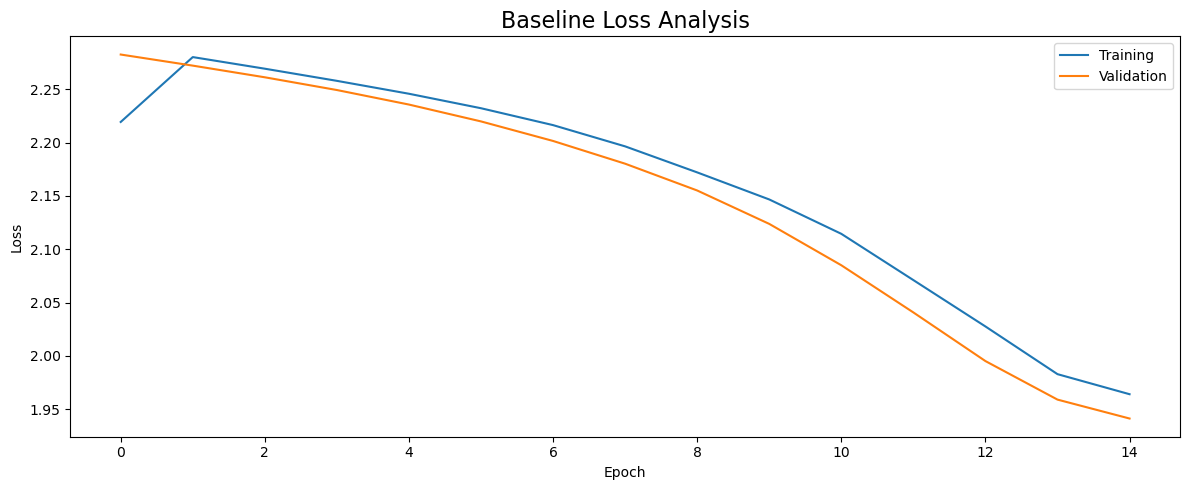

In [21]:
plot_accuracy_loss(train_losses, val_losses, dataset_name)

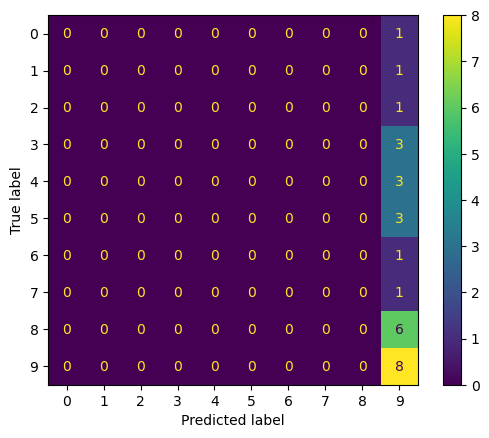

In [22]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig(results_path + f'{dataset_name}_confusion_matrix.png')
plt.show()

In [27]:
if os.path.isfile(model_evaluation_results_file_path):
    # If the file exists, read it into a DataFrame
    df_model_train_eval_results = pd.read_csv(model_evaluation_results_file_path, index_col=0)
    print("CSV file found. DataFrame loaded.")
else:
    # If the file does not exist, create a new DataFrame
    # Example: Creating a DataFrame with the specified columns and indexes
    data = {
        'precision': [],
        'recall': [],
        'f1': [],
        'accuracy': []
    }
    model_names = []  # List of model names for the index, e.g., ['model1', 'model2']
    df_model_train_eval_results = pd.DataFrame(data, index=model_names)
    print("CSV file not found. New DataFrame created.")


if dataset_name in df_model_train_eval_results.index:
    # Update the existing row
    df_model_train_eval_results.loc[dataset_name] = [precision, recall, f1, accuracy]
    print(f"Updated existing model: {dataset_name}")
else:
    # Append a new row
    df_model_train_eval_results.loc[dataset_name] = [precision, recall, f1, accuracy]
    print(f"Added new model: {dataset_name}")

df_model_train_eval_results.to_csv(model_evaluation_results_file_path)
df_model_train_eval_results

CSV file found. DataFrame loaded.
Updated existing model: Baseline


,precision,recall,f1,accuracy
Baseline,0.081633,0.285714,0.126984,0.285714


## Prediction

In [29]:
#baseline + AE
if train_data_selection == 1:
    train_dataset = DataLoader(train_original_dataset, batch_size=64, shuffle=True)
    dataset_name = "baseline_AE"
#baseline + GAN
elif train_data_selection == 2:
    train_dataset = DataLoader(train_subset, batch_size=64, shuffle=True)
    dataset_name = "baseline_GAN"
#AE
elif train_data_selection == 3:
    train_dataset = DataLoader(train_subset, batch_size=64, shuffle=True)
    dataset_name = "AE"
#GAN
elif train_data_selection == 4:
    train_dataset = DataLoader(train_subset, batch_size=64, shuffle=True)
    dataset_name = "GAN"
#baseline
else:
    train_dataset = train_original_dataset
    dataset_name = "Baseline"

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
ccnn,train_loss = train_model(model, criterion, optimizer, train_loader, num_epochs, device)

Epoch 1/15, Step 1/9, Loss: 3.0493
Epoch 1/15, Step 2/9, Loss: 2.3577
Epoch 1/15, Step 3/9, Loss: 2.3327
Epoch 1/15, Step 4/9, Loss: 2.5776
Epoch 1/15, Step 5/9, Loss: 2.3176
Epoch 1/15, Step 6/9, Loss: 1.6805
Epoch 1/15, Step 7/9, Loss: 1.2839
Epoch 1/15, Step 8/9, Loss: 1.2314
Epoch 1/15, Step 9/9, Loss: 1.2382
Epoch 1 average loss: 2.0076639652252197
Epoch 2/15, Step 1/9, Loss: 2.9395
Epoch 2/15, Step 2/9, Loss: 2.1690
Epoch 2/15, Step 3/9, Loss: 2.1242
Epoch 2/15, Step 4/9, Loss: 2.5492
Epoch 2/15, Step 5/9, Loss: 2.3299
Epoch 2/15, Step 6/9, Loss: 1.6324
Epoch 2/15, Step 7/9, Loss: 1.2423
Epoch 2/15, Step 8/9, Loss: 1.1508
Epoch 2/15, Step 9/9, Loss: 1.1141
Epoch 2 average loss: 1.9168272150887384
Epoch 3/15, Step 1/9, Loss: 3.0865
Epoch 3/15, Step 2/9, Loss: 2.1968
Epoch 3/15, Step 3/9, Loss: 2.1057
Epoch 3/15, Step 4/9, Loss: 2.6106
Epoch 3/15, Step 5/9, Loss: 2.4200
Epoch 3/15, Step 6/9, Loss: 1.6232
Epoch 3/15, Step 7/9, Loss: 1.0777
Epoch 3/15, Step 8/9, Loss: 0.9557
Epoch 3/

In [42]:
image_ids = range(1, test_size+1)

def model_prediction(model,test_loader,dataset_name,device):
    model.to(device)
    model.eval()
    predictions = []

    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            outputs = model(images)
            # Assuming you're interested in the highest probability class
            _, predicted_labels = torch.max(outputs, 1)
            predictions.extend(predicted_labels.cpu().numpy())
    print(predictions)
    real_labels_predictions = [int(labels[p]) for p in predictions]    
    prediction_df = pd.DataFrame({
        'ID': image_ids,
        'Class': real_labels_predictions
    })
    prediction_df.to_csv(f'{predictions_path}{dataset_name}.csv', index=False)

In [43]:
model_prediction(ccnn,test_loader,dataset_name,device)

[9, 8, 9, 8, 8, 8, 5, 8, 8, 9, 8, 9, 9, 4, 8, 4, 8, 8, 4, 8, 8, 8, 9, 9, 9, 8, 9, 3, 4, 9, 9, 4, 8, 8, 8, 9, 9, 8, 8, 4, 9, 8, 8, 8, 9, 8, 4, 8, 5, 9, 9, 4, 8, 9, 9, 4, 4, 4, 8, 9, 9, 8, 8, 4, 4, 9, 5, 4, 4, 9, 9, 4, 8, 9, 8, 9, 9, 9, 8, 4, 8, 4, 4, 4, 9, 9, 9, 9, 9, 8, 9, 8, 8, 4, 9, 4, 8, 9, 4, 8, 9, 4, 4, 8, 9, 4, 9, 8, 8, 4, 9, 9, 8, 8, 8, 4, 8, 8, 9, 8, 4, 8, 9, 4, 4, 8, 9, 4, 4, 8, 8, 9, 4, 8, 9, 8, 8, 4, 8, 8, 4, 8, 9, 8, 9, 9, 8, 8, 4, 3, 9, 9, 8, 4, 8, 8, 8, 5, 4, 9, 8, 8, 9, 9, 4, 4, 4, 5, 8, 8, 4, 8, 4, 8, 4, 4, 9, 4, 8, 9, 9, 8, 9, 4, 5, 5, 4, 8, 9, 9, 9, 9, 8, 9, 8, 9, 9, 9, 8, 8, 8, 8, 9, 8, 9, 8, 8, 8, 8, 9, 4, 8, 8, 8, 8, 9, 8, 4, 9, 9, 8, 4, 8, 8, 8, 4, 5, 9, 9, 8, 8, 9, 9, 4, 8, 3, 8, 4, 8, 9, 3, 9, 4, 8, 8, 9, 9, 5, 9, 9, 9, 8, 8, 8, 9, 9, 9, 9, 5, 9, 9, 8, 8, 4, 9, 4, 8, 9, 8, 8, 9, 8, 9, 9, 9, 8, 8, 3, 8, 4, 8, 8, 8, 9, 8, 8, 9, 8, 8, 5, 9, 9, 9, 9, 8, 8, 9, 9, 8, 9, 8, 9, 9, 4, 8, 9, 8, 9, 8, 9, 9, 8, 4, 3, 9, 9, 8, 8, 4, 8, 4, 9, 8, 8, 8, 5, 4, 9, 4, 9, 9, 9, 8, 